In [1]:
## Options
import pandas as pd
from PI_client import pi_client
pi = pi_client()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%load_ext autoreload
%autoreload 2

### Local Data Loading

In [2]:
# filePath = 'data/OATtest.xlsx'
filePath = 'data/arc2yeardata.xlsx'
data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True)
print(data.columns)

Index([u'chw', u'elec', u'steam'], dtype='object')


### PI Data Loading

In [3]:
tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

print(tags)

[u'Shields_ChilledWater_Demand kBTUperHr', u'Shields_ChilledWater_Demand_kBtu', u'Shields_Electricity_Demand_kBtu', u'Shields_Steam_Demand_kBtu']


#### Pull tags

In [4]:
startDate = '2017-01-01'
endDate = '2018-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

# data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

In [5]:
## Imports

## Mac imports
# import sys
# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

## Main Imports
import mnv12 as mnv
print(mnv.version)
import matplotlib.pyplot as plt
print("Success!")

Version 1.2
Success!


# Data Section

Loaded pd.DataFrame - using column "chw"
Q(75%): 98.31 Q(25%): 0.13
IQR value is 98.19
Ceiling adjusted by IQR - Now 491.06


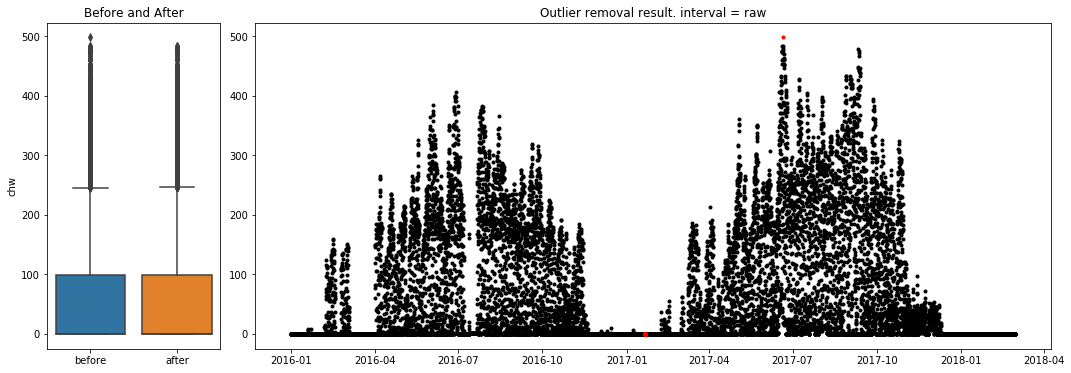

ON FILE


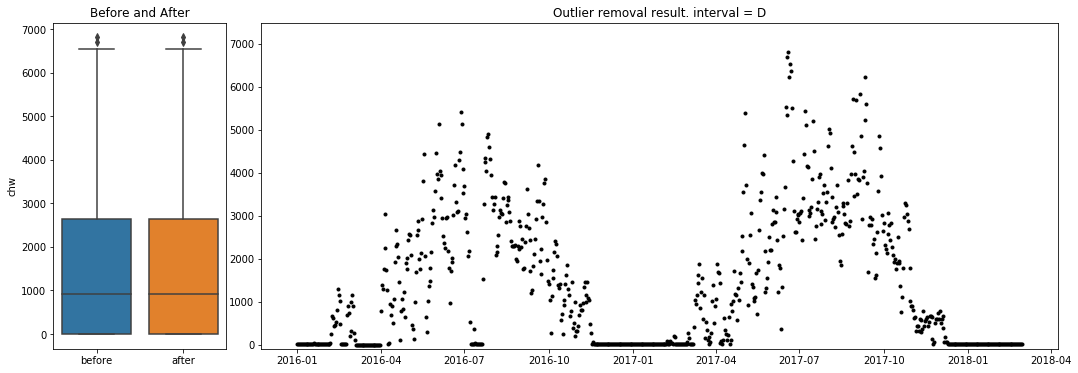

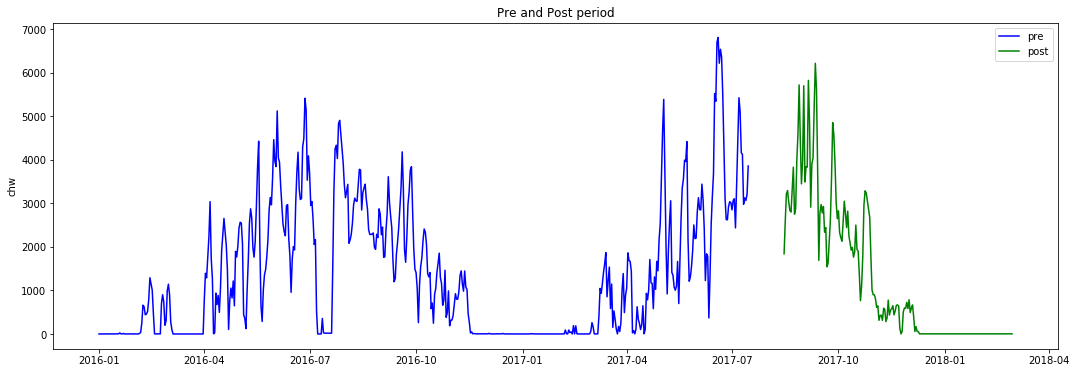

In [6]:
inputDict = {'IQRmult' : 4.0,
             'IQR' : 'y', 
             'resampleRate' : 'D', #'D' for daily 'H' for hourly
             'verbosity' : 3,
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2015-01-01','2017-07-15','2017-08-15','2018-04-01'], #only needed with sliceType : 'ranges'
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data[data.columns[0:2]], inputDict)
dc.default_clean()

## Run the next line incase the y-range is FUBAR
dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1)) 

# plot 3
dc._pre_post_plot()

# Many Linear Models

Could not calculate VIF for C(hour)
Exception caught: Arrays cannot be empty
Could not calculate VIF for C(hour)
Exception caught: Arrays cannot be empty
        AIC       AR2        R2    cvrmse postDiff                            params                                            summary
23  6867.82  0.889556  0.890049  0.365529 -52194.3                         CDH + HDH                              OLS Regression Res...
12  6867.82  0.889556  0.890049  0.365529 -52194.3               CDH + HDH + C(hour)                              OLS Regression Res...
3   6868.95  0.889524  0.890264  0.365583 -52191.5            CDH + HDH + C(weekend)                              OLS Regression Res...
13  6868.95  0.889524  0.890264  0.365583 -52191.5  CDH + HDH + C(hour) + C(weekend)                              OLS Regression Res...
32  6875.92  0.887547  0.888049  0.368839 -50133.4              CDH + HDH2 + C(hour)                              OLS Regression Res...


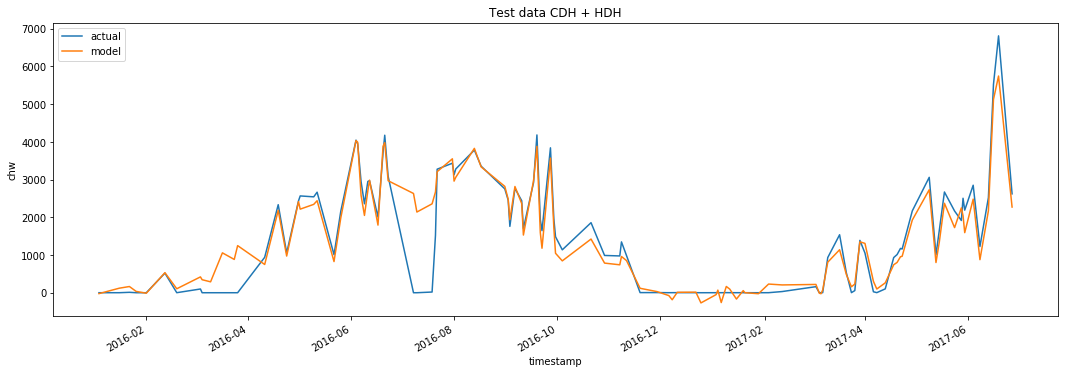

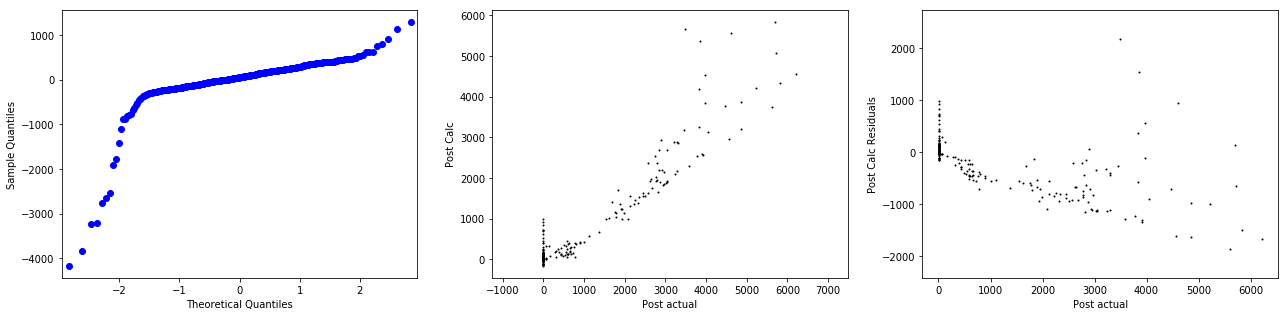

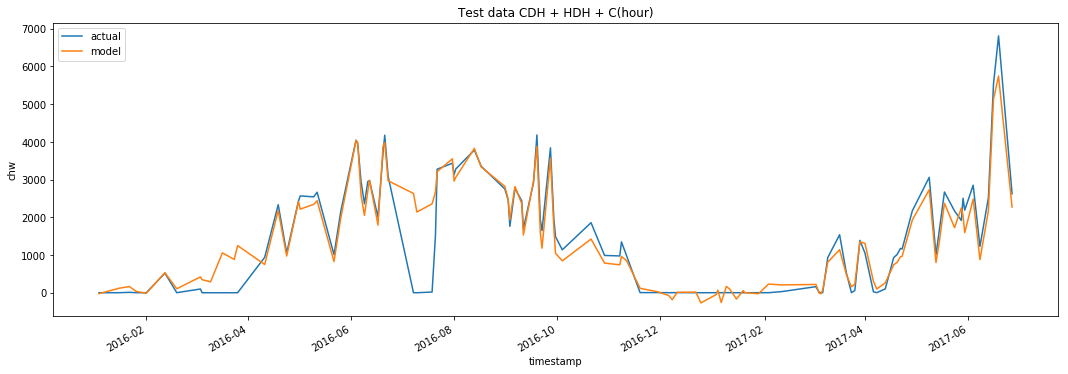

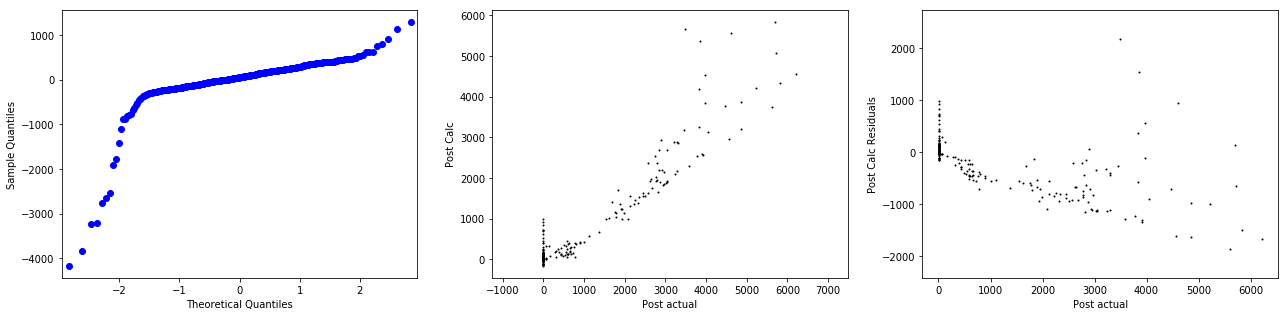

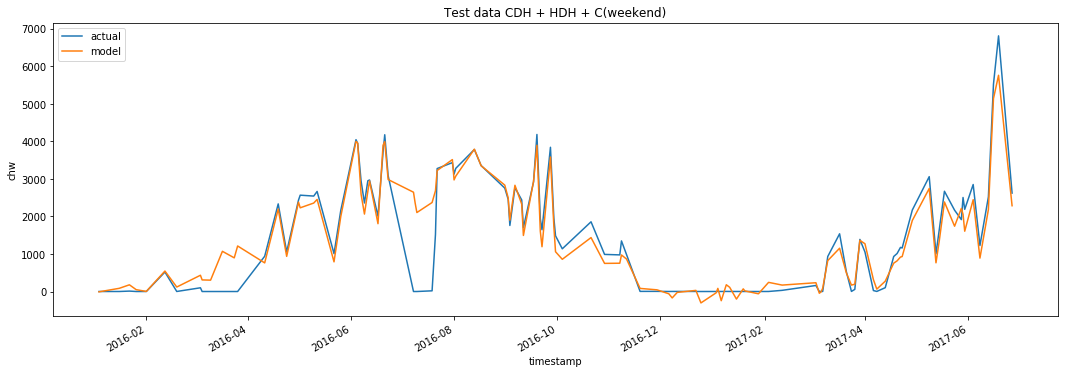

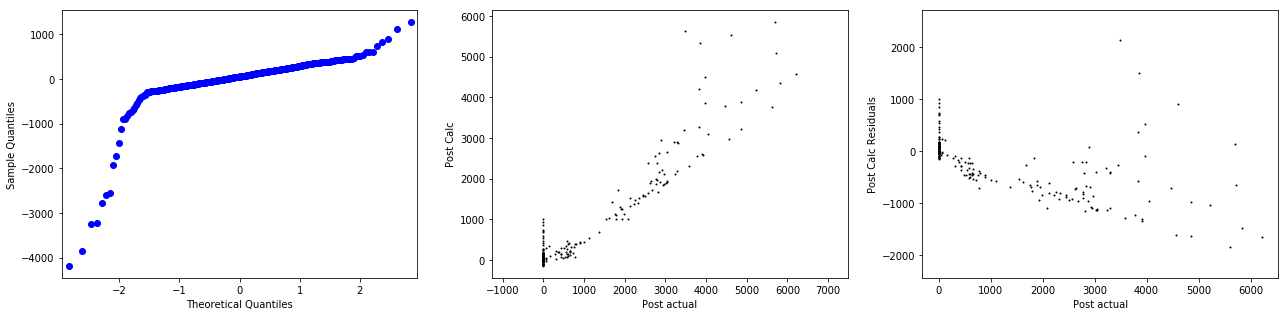

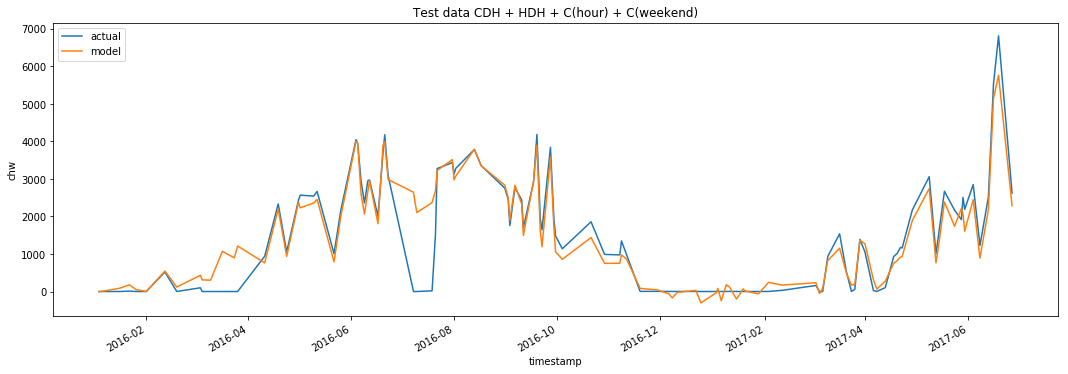

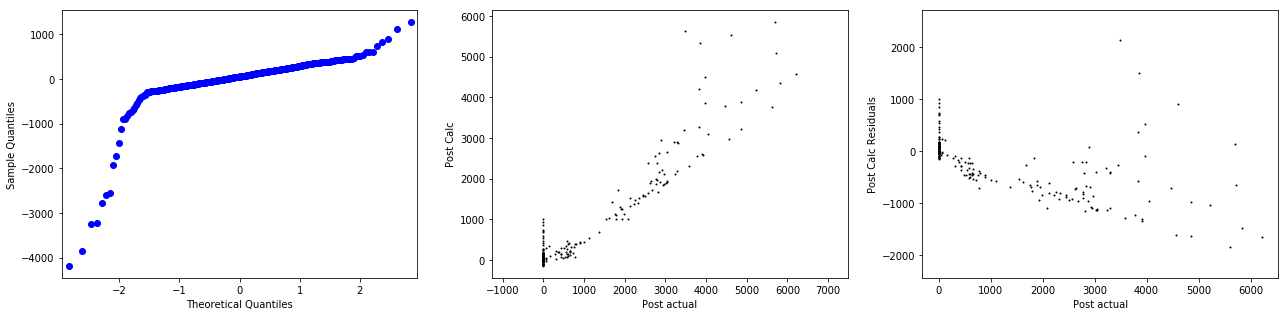

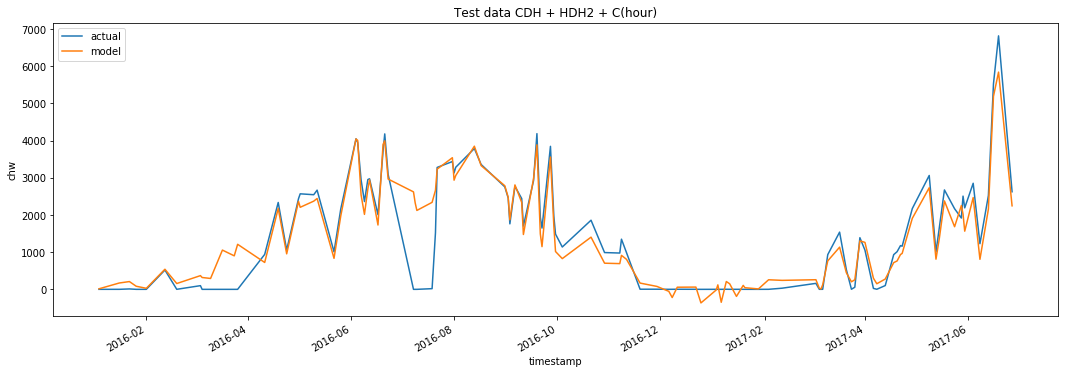

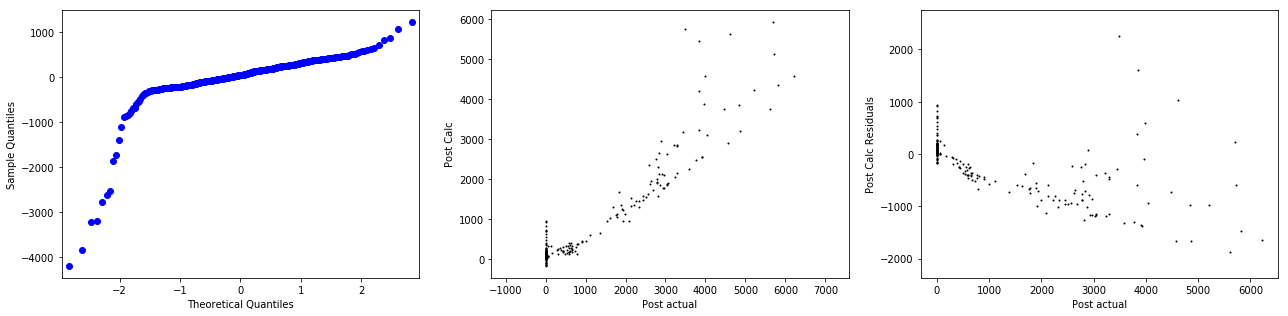

In [12]:
modelDict = {'params': 'CDH + HDH + C(month) + C(weekend)',
             'testTrainSplit': 'random',
             'randomState': 421990,
             'testSize': 0.2,
             'commodityRate': 0.056,
             'paramList': ['','C(hour)','C(weekend)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(5)
modelDict['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

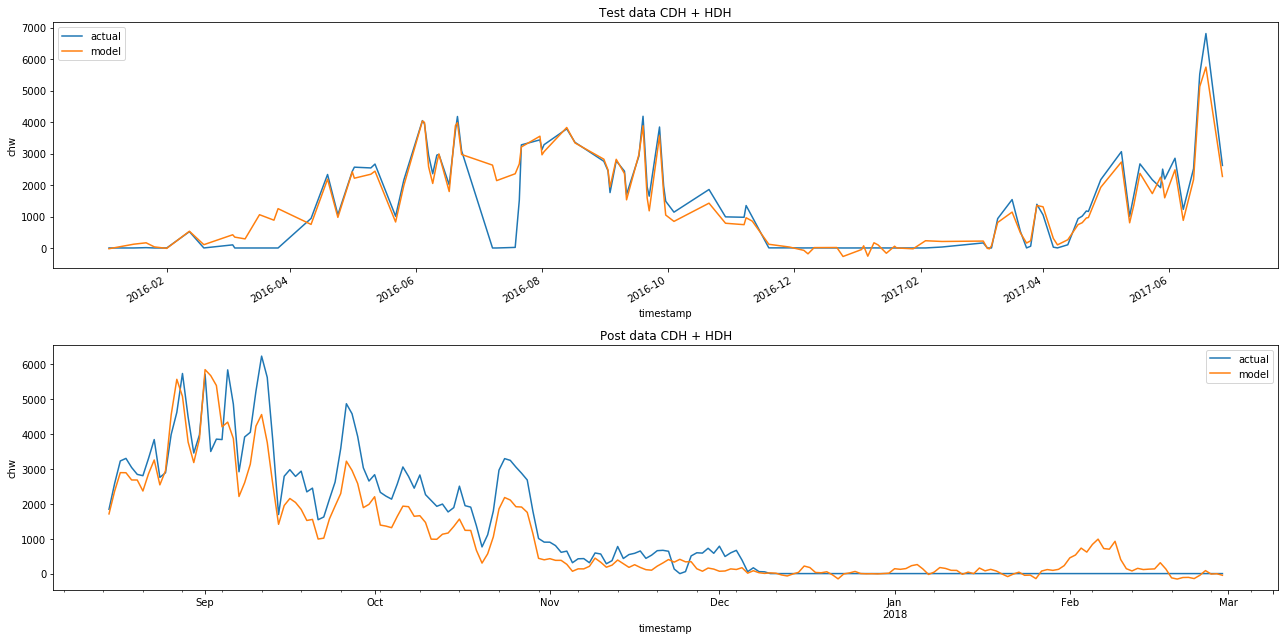

            VIF
const  6.735956
HDH    1.926168
CDH    1.926168


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chw   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1805.
Date:                Wed, 13 Jun 2018   Prob (F-statistic):          1.54e-214
Time:                        13:59:45   Log-Likelihood:                -3430.9
No. Observations:                 449   AIC:                             6868.
Df Residuals:                     446   BIC:                             6880.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    516.6856     61.921      8.344      0.000     394.992     638.379
CDH            9.7890      0.251     39.021      0.000       9.296      10.282
HDH           -1.4209      0.242     -5.865      0.000      -1.897      -0.945
==============================================================================
Omnibus:                      457.370   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17125.110
Skew:                          -4.565   Prob(JB):                         0.00
Kurtosis:                      31.845   Cond. No.                         521.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()


plt.show() # Show plot before Stats summary
print(mod.vif)
mod.Fit.summary()

### Savings

Savings = $-2942.51


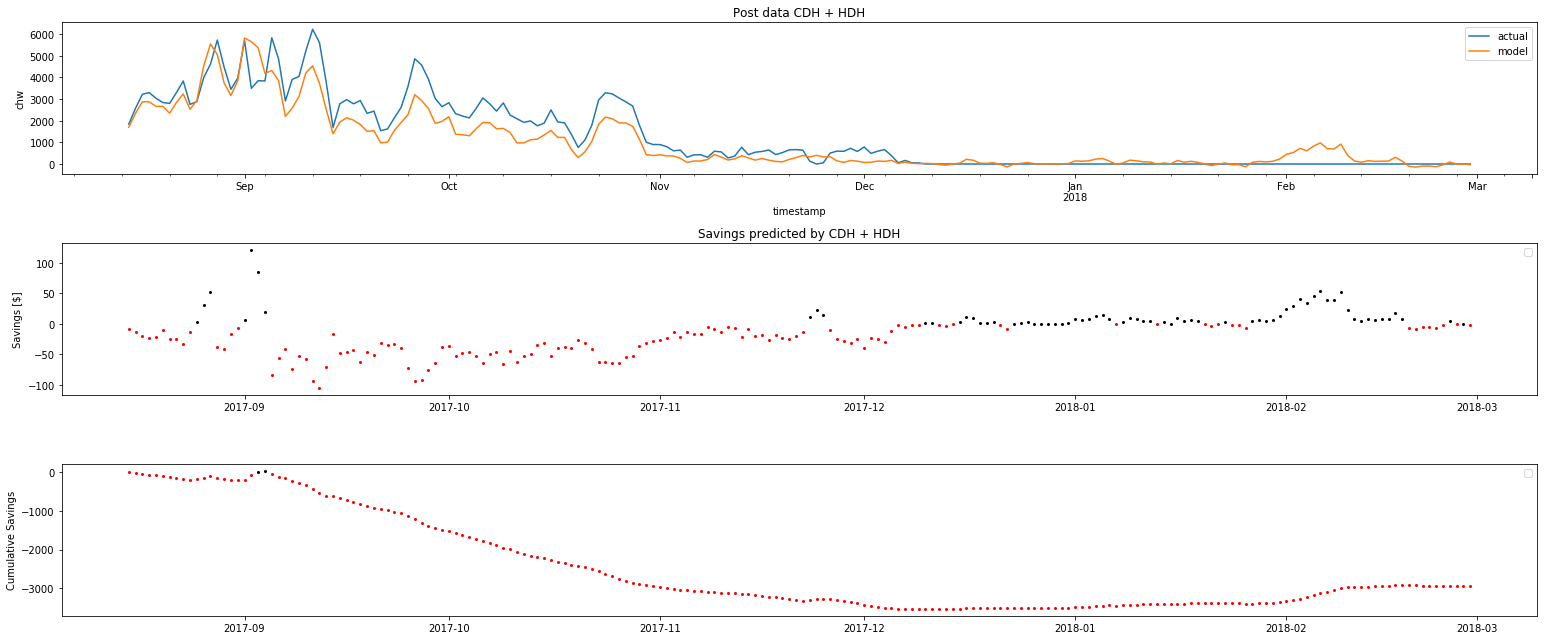

In [9]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'

print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,2)))
mod.savings_plot(yaxis='dollars')